In [1]:
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from tqdm import tqdm
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, confusion_matrix, classification_report,
    roc_curve, accuracy_score, precision_recall_curve, average_precision_score
)

# Real data cancer classifier

In [5]:
# Load expression and metadata
tpm_norm = pd.read_csv("data/pnas_normal_tpm.txt", sep='\t')
tpm_norm['gene_id'] = tpm_norm.index
readcounts_norm = pd.read_csv("data/pnas_normal_readcounts.txt", sep='\t')
readcounts_norm['gene_id'] = readcounts_norm.index

# Load expression and metadata
tpm = pd.read_csv("data/pnas_tpm_96_nodup.txt", sep='\t', header=None)
tpm.columns = ['gene_id'] + [f"C{i}" for i in range(1, tpm.shape[1])]
readcounts = pd.read_csv("data/pnas_readcounts_96_nodup.txt", sep='\t', header=None)
readcounts.columns = ['gene_id'] + [f"C{i}" for i in range(1, tpm.shape[1])]
patient_info = pd.read_csv("data/pnas_patient_info.csv")
sample_ids = [f"C{i}" for i in range(1, 97)]
patient_info["sampleID"] = sample_ids

# Filter for preselected genes
tpm = tpm.set_index('gene_id')
readcounts_filtered = readcounts.set_index('gene_id')
tpm_norm = tpm_norm.set_index('gene_id')
readcounts_norm = readcounts_norm.set_index('gene_id')

shared_genes = set(readcounts_norm.index) & set(readcounts_filtered.index) & set(tpm.index) & set(tpm_norm.index)

tpm_norm = tpm_norm[tpm_norm.index.isin(shared_genes)]
readcounts_norm = readcounts_norm[readcounts_norm.index.isin(shared_genes)]
tpm = tpm[tpm.index.isin(shared_genes)]
readcounts_filtered = readcounts_filtered[readcounts_filtered.index.isin(shared_genes)]
tpm_combined = pd.concat([tpm_norm, tpm], axis=1)

sample_order = tpm_combined.columns
labels = [0 for i in range(32)] + [1 for i in range(96)]

# rc_df = tpm_combined.T
# rc_df['label'] = labels
# p_values = []
# for gene in rc_df.columns[:-1]:
#     group1 = rc_df[rc_df['label'] == 0][gene]
#     group2 = rc_df[rc_df['label'] == 1][gene]
#     stat, p = ttest_ind(group1, group2, equal_var=False)
#     p_values.append((gene, p))

# with open("genes_p_values.pkl", "wb") as f:
#     pickle.dump(p_values, f)
    
with open("data/genes_p_values.pkl", "rb") as f:
    p_values = pickle.load(f)
    
# Rank genes
ranked_genes = [gene for gene, _ in sorted(p_values, key=lambda x: x[1])]

In [9]:
tpm_combined.shape

(60675, 128)

In [10]:
max_zero_fraction = 0.9
max_zeros_allowed = int(tpm_combined.shape[1] * max_zero_fraction)
zero_counts = (tpm_combined == 0).sum(axis=1)
tpm_filtered = tpm_combined[zero_counts <= max_zeros_allowed]

In [11]:
tpm_filtered.shape

(50519, 128)

In [13]:
ranked_genes[0]

'ENSG00000061455'

In [14]:
ranked_genes[1]

'ENSG00000102287'

/var/folders/42/x61503vj4jx8wmb1ts75xmyh0000gn/T/ipykernel_36117/2624105592.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=plot_df, x='Group', y='Expression TPM', palette='Set2')


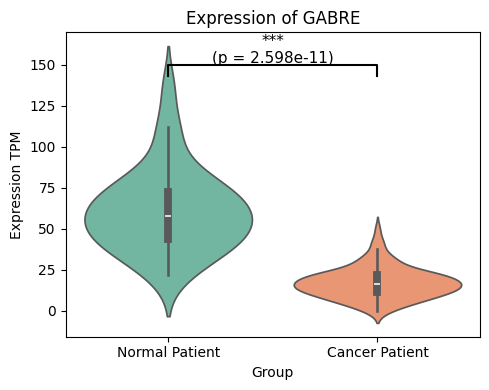

In [22]:
gene_id = 'ENSG00000102287'
normal_vals = tpm_filtered.loc[gene_id, tpm_filtered.columns[tpm_filtered.columns.str.contains("N")]]
cancer_vals = tpm_filtered.loc[gene_id, tpm_filtered.columns[tpm_filtered.columns.str.contains("C")]]
plot_df = pd.DataFrame({
    'Expression TPM': pd.concat([normal_vals, cancer_vals]),
    'Group': ['Normal Patient'] * len(normal_vals) + ['Cancer Patient'] * len(cancer_vals)
})

# Statistical test
stat, pval = ttest_ind(normal_vals, cancer_vals, equal_var=False)

# Determine significance label
if pval < 0.001:
    sig_label = '***'
elif pval < 0.01:
    sig_label = '**'
elif pval < 0.05:
    sig_label = '*'
else:
    sig_label = 'ns'

# Plot
plt.figure(figsize=(5, 4))
ax = sns.violinplot(data=plot_df, x='Group', y='Expression TPM', palette='Set2')
plt.title(f"Expression of GABRE")

# Add annotation
y_max = plot_df['Expression TPM'].max()
y_offset = y_max * 0.1
x1, x2 = 0, 1  # positions of groups

# Draw the connecting line
plt.plot([x1, x1, x2, x2], 
         [y_max + y_offset/2, y_max + y_offset, y_max + y_offset, y_max + y_offset/2], 
         lw=1.5, c='black')

# Add p-value and significance label
plt.text((x1 + x2) / 2, y_max + y_offset * 0.95, 
         f"{sig_label}\n(p = {pval:.3e})", 
         ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

In [164]:
pseudocount = 1e-6
tpm_logged = tpm_filtered + pseudocount
geometric_means = np.exp(np.log(tpm_logged).mean(axis=1))
ratios = tpm_logged.div(geometric_means, axis=0)
size_factors = ratios.median(axis=0)
tpm_normalized = tpm_filtered.div(size_factors, axis=1)

In [115]:
tpm_normalized.shape

(50519, 128)

In [132]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [131]:
tpm_filtered_log = np.log2(tpm_filtered + pseudocount)

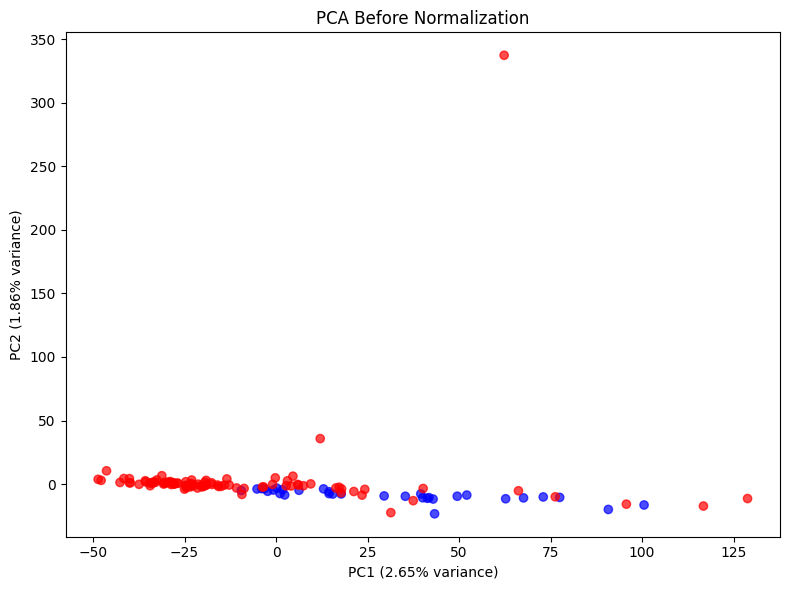

In [153]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
def plot_pca(data, title, labels):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.T)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_scaled)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='bwr', alpha=0.7)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title(title)
    plt.tight_layout()

plot_pca(tpm_filtered, 'PCA Before Normalization', labels)

In [146]:
tpm_validation = pd.read_csv("data/validation_exon_tpm", sep='\t').T
valid_cancer_patient = pd.read_excel("data/validation_bc_meta.xlsx")
valid_normal_patient = pd.read_excel("data/validation_normal_meta.xlsx")
cancer_patients = list(valid_cancer_patient['Mapping ID'])
normal_patients = list(valid_normal_patient['Mapping ID'])
validation_labels = tpm_validation.index.map(
    lambda x: 1 if x in cancer_patients else (0 if x in normal_patients else np.nan)
)

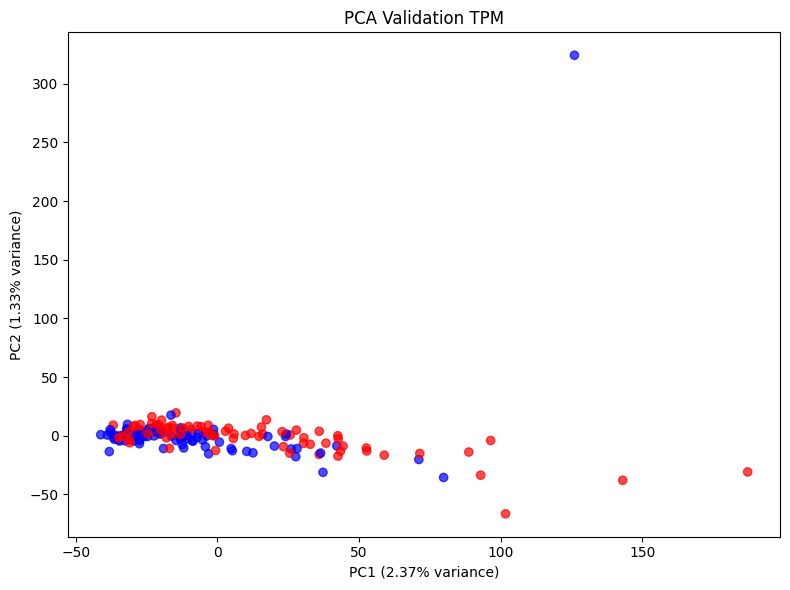

In [152]:
plot_pca(tpm_validation.T, 'PCA Validation TPM', validation_labels)

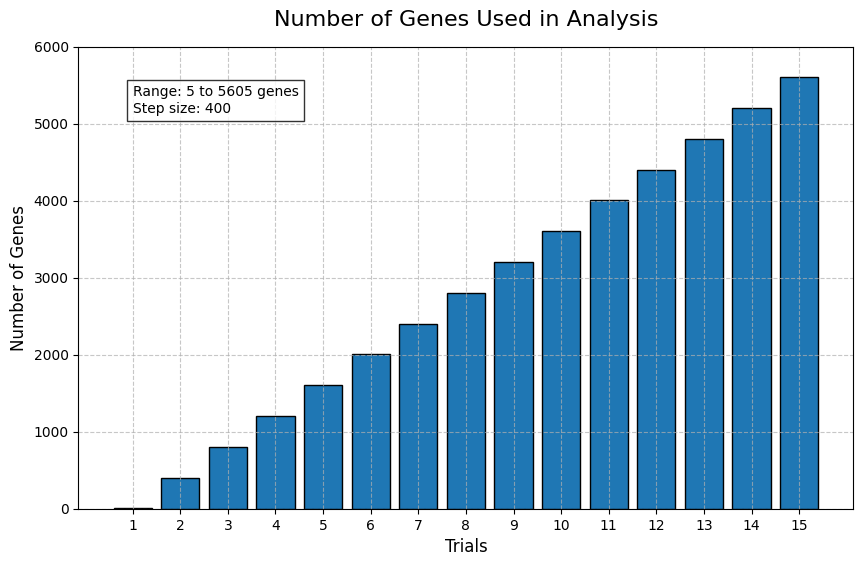

In [185]:
gene_nums = list(range(5, 6000, 400))

plt.figure(figsize=(10, 6))
steps = list(range(1, len(gene_nums) + 1))
plt.bar(steps, gene_nums, color='#1f77b4', edgecolor='black', width=0.8)

plt.title("Number of Genes Used in Analysis", pad=15, fontsize=16)
plt.xlabel("Trials", fontsize=12)
plt.ylabel("Number of Genes", fontsize=12)
plt.xticks(steps)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 6000)

plt.text(1, 5500, "Range: 5 to 5605 genes\nStep size: 400", ha='left', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.show()

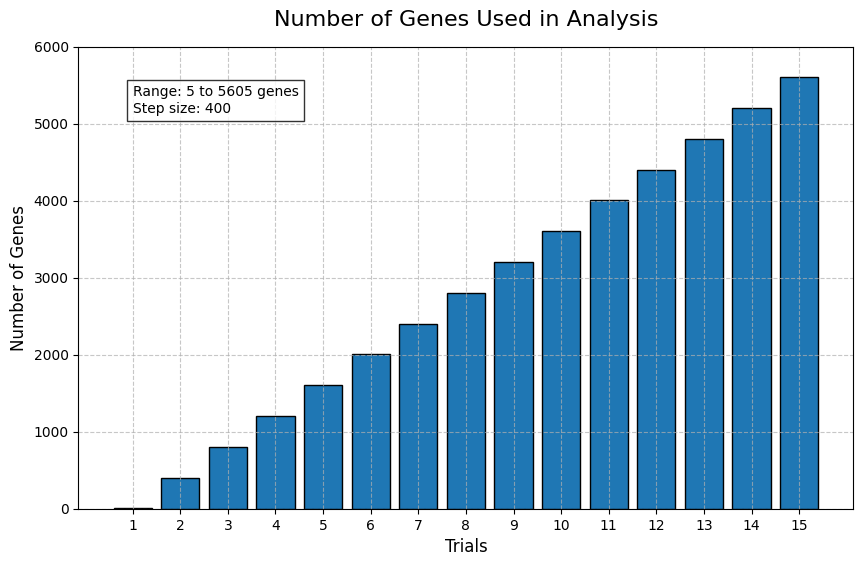

In [185]:
gene_nums = list(range(5, 6000, 400))

plt.figure(figsize=(10, 6))
steps = list(range(1, len(gene_nums) + 1))
plt.bar(steps, gene_nums, color='#1f77b4', edgecolor='black', width=0.8)

plt.title("Number of Genes Used in Analysis", pad=15, fontsize=16)
plt.xlabel("Trials", fontsize=12)
plt.ylabel("Number of Genes", fontsize=12)
plt.xticks(steps)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 6000)

plt.text(1, 5500, "Range: 5 to 5605 genes\nStep size: 400", ha='left', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.show()


======== Starting gene‐loop for LogisticRegression ========


LogisticRegression gene set size loop:  20%|███████▊                               | 3/15 [00:00<00:00, 19.26it/s]

  → LogisticRegression new best: num_genes=5, avg_internal_AUC=0.9646
  → LogisticRegression new best: num_genes=405, avg_internal_AUC=0.9750


LogisticRegression gene set size loop:  33%|█████████████                          | 5/15 [00:00<00:00, 12.87it/s]

  → LogisticRegression new best: num_genes=1205, avg_internal_AUC=0.9903


LogisticRegression gene set size loop: 100%|██████████████████████████████████████| 15/15 [00:03<00:00,  4.82it/s]



======== Starting gene‐loop for SVM ========


SVM gene set size loop:  27%|██████████████▍                                       | 4/15 [00:00<00:00, 24.24it/s]

  → SVM new best: num_genes=5, avg_internal_AUC=0.5403


SVM gene set size loop: 100%|█████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.06it/s]



======== Starting gene‐loop for RandomForest ========


RandomForest gene set size loop:   7%|███                                          | 1/15 [00:00<00:03,  4.08it/s]

  → RandomForest new best: num_genes=5, avg_internal_AUC=0.9000


RandomForest gene set size loop:  20%|█████████                                    | 3/15 [00:00<00:03,  3.57it/s]

  → RandomForest new best: num_genes=805, avg_internal_AUC=0.9062


RandomForest gene set size loop:  40%|██████████████████                           | 6/15 [00:01<00:02,  3.18it/s]

  → RandomForest new best: num_genes=2005, avg_internal_AUC=0.9090


RandomForest gene set size loop: 100%|████████████████████████████████████████████| 15/15 [00:05<00:00,  2.93it/s]



======== Starting gene‐loop for MLP ========


MLP gene set size loop:   0%|                                                              | 0/15 [00:00<?, ?it/s]/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
MLP gene set size loop:   7%|███▌                                                  | 1/15 [00:00<00:03,  4.33it/s]

  → MLP new best: num_genes=5, avg_internal_AUC=0.9181


MLP gene set size loop:  27%|██████████████▍                                       | 4/15 [00:00<00:01,  7.30it/s]

  → MLP new best: num_genes=805, avg_internal_AUC=0.9201


MLP gene set size loop:  47%|█████████████████████████▏                            | 7/15 [00:01<00:01,  5.10it/s]

  → MLP new best: num_genes=2405, avg_internal_AUC=0.9257


MLP gene set size loop:  60%|████████████████████████████████▍                     | 9/15 [00:02<00:02,  2.59it/s]

  → MLP new best: num_genes=3205, avg_internal_AUC=0.9285


MLP gene set size loop: 100%|█████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.50it/s]



======== Starting gene‐loop for XGBoost ========


XGBoost gene set size loop:   7%|███▎                                              | 1/15 [00:00<00:04,  2.94it/s]

  → XGBoost new best: num_genes=5, avg_internal_AUC=0.9000


XGBoost gene set size loop:  20%|██████████                                        | 3/15 [00:02<00:09,  1.24it/s]

  → XGBoost new best: num_genes=805, avg_internal_AUC=0.9417


XGBoost gene set size loop: 100%|█████████████████████████████████████████████████| 15/15 [00:44<00:00,  2.95s/it]


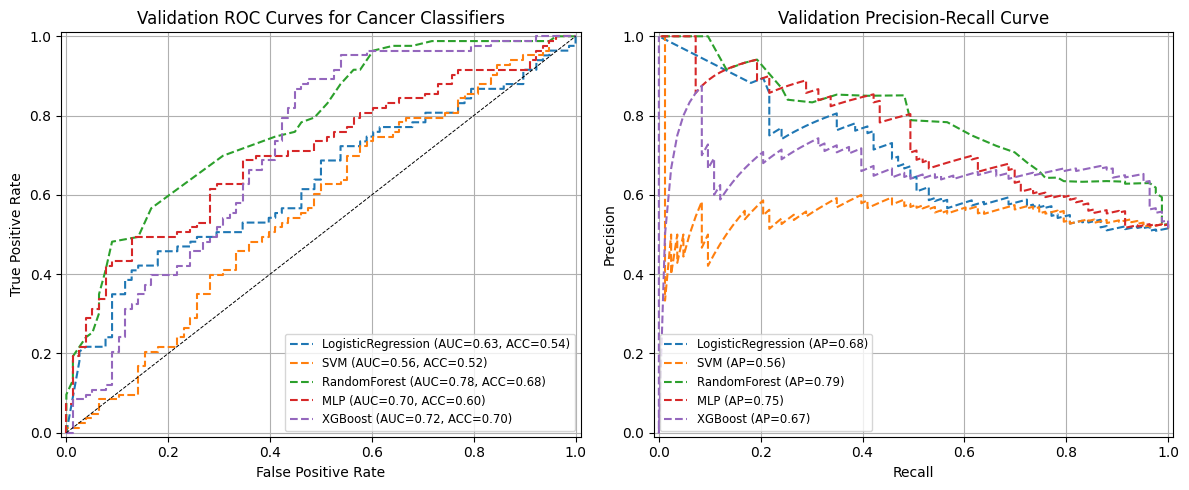

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ────────────────────────────────────────────────────────────────────────────────
# 1. Define the five classifiers (same as before)
# ────────────────────────────────────────────────────────────────────────────────
classifiers = {
    'LogisticRegression': lambda: LogisticRegression(
        solver='liblinear',
        C=1.0,
        max_iter=2000,
        random_state=42
    ),
    'SVM': lambda: SVC(
        kernel='rbf',
        C=1.0,
        probability=True,
        random_state=42
    ),
    'RandomForest': lambda: RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ),
    'MLP': lambda: MLPClassifier(
        hidden_layer_sizes=(100,),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42
    ),
    'XGBoost': lambda: xgb.XGBClassifier(
        eval_metric='logloss',
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    )
}

# ────────────────────────────────────────────────────────────────────────────────
# 2. Gene‐loop + fit each classifier, but now SAVE `train_features` instead of `selected_genes`
# ────────────────────────────────────────────────────────────────────────────────
gene_nums = list(range(5, 6000, 400))
results   = {}  # will store: results[clf_name] = {'best_features': [...], 'best_model': fitted_model}
all_aucs = {clf_name: {} for clf_name in classifiers}
all_accs = {clf_name: {} for clf_name in classifiers}

for clf_name, clf_builder in classifiers.items():
    best_features = None
    best_model    = None
    best_auc      = -1.0

    # Re‐compute X_all exactly as in your notebook:
    tpm_df = tpm_normalized.copy()
    X_all  = tpm_df[sample_order].T
    y_all  = np.array(labels)

    print(f"\n======== Starting gene‐loop for {clf_name} ========")
    for num_genes in tqdm(gene_nums, desc=f"{clf_name} gene set size loop"):
        # 1. pick the top num_genes from ranked_genes, intersect with X_all.columns
        selected_genes = sorted(set(ranked_genes[:num_genes]) & set(X_all.columns))

        # 2. build X (samples × selected_genes) and y
        X = X_all[selected_genes].copy()
        y = y_all.copy()

        # 3. Perform 5 internal splits exactly as before
        aucs = []
        accs = []
        for _ in range(5):
            idx_r = np.where(y == 1)[0]
            idx_n = np.where(y == 0)[0]

            # 20 positives / 20 negatives for training
            train_r = np.random.choice(idx_r, 20, replace=False)
            train_n = np.random.choice(idx_n, 20, replace=False)

            # Remainder → test candidates
            test_r = np.setdiff1d(idx_r, train_r)
            test_n = np.setdiff1d(idx_n, train_n)

            # From those remainders, pick 12 positives & 12 negatives
            test_r = np.random.choice(test_r, 12, replace=False)
            test_n = np.random.choice(test_n, 12, replace=False)

            train_idx = np.concatenate([train_r, train_n])
            test_idx  = np.concatenate([test_r, test_n])

            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Remove any all‐zero columns in the training set
            non_zero_cols = (X_train != 0).any(axis=0)
            X_train = X_train.loc[:, non_zero_cols]
            X_test  = X_test.loc[:, non_zero_cols]

            # Fit the classifier on the 40‐sample train set
            model = clf_builder()
            model.fit(X_train, y_train)

            # Compute test‐set AUC
            y_pred_prob = model.predict_proba(X_test)[:, 1]
            acc = accuracy_score(y_test, model.predict(X_test))
            auc = roc_auc_score(y_test, y_pred_prob)
            aucs.append(auc)
            accs.append(acc)

        current_auc = np.mean(aucs)
        all_aucs[clf_name][num_genes] = aucs
        all_accs[clf_name][num_genes] = accs
        if current_auc > best_auc:
            best_auc = current_auc

            # Re‐fit “best_model” on *all* samples using exactly the same non‐zero filter:
            X_full      = X_all[selected_genes].copy()
            nz_full     = (X_full != 0).any(axis=0)
            X_full      = X_full.loc[:, nz_full]
            train_features = list(X_full.columns)  # ← Save these exact column names

            refit_model = clf_builder()
            refit_model.fit(X_full, y_all)
            best_model    = refit_model
            best_features = train_features

            print(f"  → {clf_name} new best: num_genes={num_genes}, avg_internal_AUC={best_auc:.4f}")

    results[clf_name] = {
        'best_features': best_features,
        'best_model':    best_model
    }


# ────────────────────────────────────────────────────────────────────────────────
# 3. Validation + ROC plotting, REINDEXING ON `best_features`
# ────────────────────────────────────────────────────────────────────────────────

# 3.1 Load validation metadata + TPM exactly as in Cell 19:
valid_cancer_patient = pd.read_excel("data/validation_bc_meta.xlsx")
valid_normal_patient = pd.read_excel("data/validation_normal_meta.xlsx")
cancer_patients = list(valid_cancer_patient['Mapping ID'])
normal_patients = list(valid_normal_patient['Mapping ID'])

tpm_valid_df = pd.read_csv("data/validation_exon_tpm", sep='\t').T
tpm_valid_df['label'] = tpm_valid_df.index.map(
    lambda x: 1 if x in cancer_patients else (0 if x in normal_patients else np.nan)
)
valid_labels = tpm_valid_df['label'].values

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ── ROC Curve Plot ──
ax_roc = axes[0]
for clf_name, res in results.items():
    best_features = res['best_features']
    best_model = res['best_model']

    X_valid_filt = tpm_valid_df.reindex(columns=best_features, fill_value=0)
    y_pred_prob = best_model.predict_proba(X_valid_filt)[:, 1]
    y_pred = best_model.predict(X_valid_filt)

    fpr, tpr, _ = roc_curve(valid_labels, y_pred_prob)
    auc = roc_auc_score(valid_labels, y_pred_prob)
    acc = accuracy_score(valid_labels, y_pred)

    ax_roc.plot(fpr, tpr, linestyle='--', label=f"{clf_name} (AUC={auc:.2f}, ACC={acc:.2f})")

ax_roc.plot([0, 1], [0, 1], "k--", linewidth=0.7)
ax_roc.set_xlim([-0.01, 1.01])
ax_roc.set_ylim([-0.01, 1.01])
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_title("Validation ROC Curves for Cancer Classifiers")
ax_roc.legend(loc="lower right", fontsize='small')
ax_roc.grid(True)

# ── Precision-Recall Plot ──
ax_pr = axes[1]
for clf_name, res in results.items():
    best_features = res['best_features']
    best_model = res['best_model']

    X_valid_filt = tpm_valid_df.reindex(columns=best_features, fill_value=0)
    y_pred_prob = best_model.predict_proba(X_valid_filt)[:, 1]

    precision, recall, _ = precision_recall_curve(valid_labels, y_pred_prob)
    ap = average_precision_score(valid_labels, y_pred_prob)

    ax_pr.plot(recall, precision, linestyle='--', label=f"{clf_name} (AP={ap:.2f})")

ax_pr.set_xlim([-0.01, 1.01])
ax_pr.set_ylim([-0.01, 1.01])
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.set_title("Validation Precision-Recall Curve")
ax_pr.legend(loc="lower left", fontsize='small')
ax_pr.grid(True)

plt.tight_layout()
plt.show()

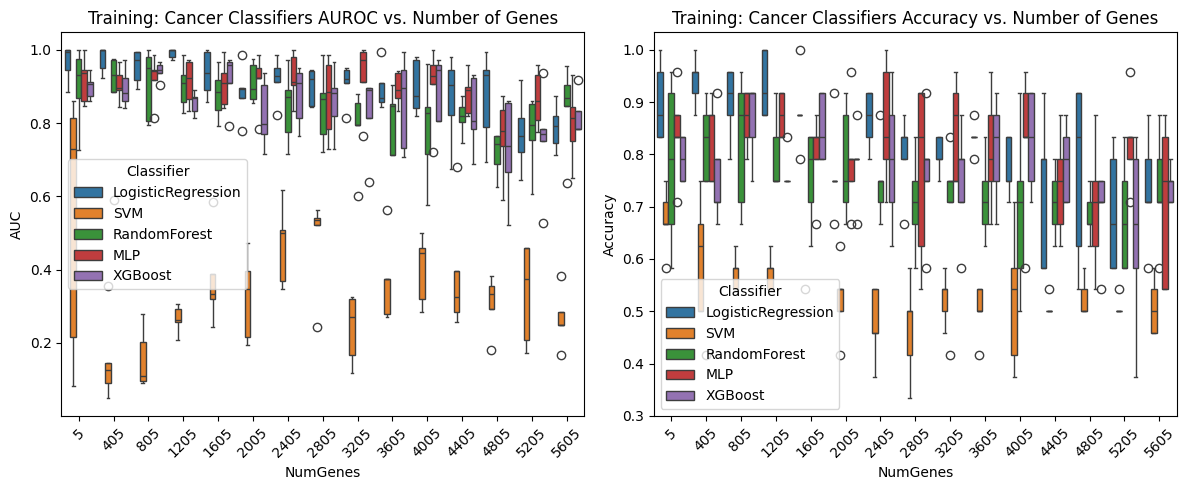

In [117]:
df_auc = pd.DataFrame([
    {'Classifier': clf, 'NumGenes': k, 'AUC': v}
    for clf, values in all_aucs.items()
    for k, lst in values.items()
    for v in lst])
df_acc = pd.DataFrame([
    {'Classifier': clf, 'NumGenes': k, 'Accuracy': v}
    for clf, values in all_accs.items()
    for k, lst in values.items()
    for v in lst])

plt.figure(figsize=(12, 5))

# AUROC
plt.subplot(1, 2, 1)
sns.boxplot(data=df_auc, x="NumGenes", y="AUC", hue="Classifier")
plt.title("Training: Cancer Classifiers AUROC vs. Number of Genes")
plt.xticks(rotation=45)

# Accuracy
plt.subplot(1, 2, 2)
sns.boxplot(data=df_acc, x="NumGenes", y="Accuracy", hue="Classifier")
plt.title("Training: Cancer Classifiers Accuracy vs. Number of Genes")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [93]:
# for clf in df_auc["Classifier"].unique():
#     plt.figure(figsize=(12, 5))
    
#     # Subset for this classifier
#     auc_sub = df_auc[df_auc["Classifier"] == clf]
#     acc_sub = df_acc[df_acc["Classifier"] == clf]
    
#     # AUROC subplot
#     plt.subplot(1, 2, 1)
#     sns.boxplot(data=auc_sub, x="NumGenes", y="AUC")
#     plt.title(f"{clf}: AUROC vs. Number of Genes")
#     plt.xticks(rotation=45)
    
#     # Accuracy subplot
#     plt.subplot(1, 2, 2)
#     sns.boxplot(data=acc_sub, x="NumGenes", y="Accuracy")
#     plt.title(f"{clf}: Accuracy vs. Number of Genes")
#     plt.xticks(rotation=45)
    
#     plt.tight_layout()
#     plt.show()


======== Starting gene‐loop for LogisticRegression ========


LogisticRegression gene set size loop:  20%|████████████████████▏                                                                                | 3/15 [00:00<00:00, 23.25it/s]

  → LogisticRegression new best: num_genes=5, avg_internal_AUC=0.9278
  → LogisticRegression new best: num_genes=405, avg_internal_AUC=0.9493
  → LogisticRegression new best: num_genes=805, avg_internal_AUC=0.9646


LogisticRegression gene set size loop:  53%|█████████████████████████████████████████████████████▊                                               | 8/15 [00:00<00:00,  8.10it/s]

  → LogisticRegression new best: num_genes=2405, avg_internal_AUC=0.9653


LogisticRegression gene set size loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.28it/s]



======== Starting gene‐loop for SVM ========


SVM gene set size loop:  27%|██████████████████████████████▉                                                                                     | 4/15 [00:00<00:00, 32.40it/s]

  → SVM new best: num_genes=5, avg_internal_AUC=0.7000


SVM gene set size loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.55it/s]



======== Starting gene‐loop for RandomForest ========


RandomForest gene set size loop:   7%|███████▏                                                                                                   | 1/15 [00:00<00:03,  4.18it/s]

  → RandomForest new best: num_genes=5, avg_internal_AUC=0.9056


RandomForest gene set size loop:  13%|██████████████▎                                                                                            | 2/15 [00:00<00:03,  3.69it/s]

  → RandomForest new best: num_genes=405, avg_internal_AUC=0.9069


RandomForest gene set size loop:  27%|████████████████████████████▌                                                                              | 4/15 [00:01<00:03,  3.46it/s]

  → RandomForest new best: num_genes=1205, avg_internal_AUC=0.9194


RandomForest gene set size loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.19it/s]



======== Starting gene‐loop for MLP ========


MLP gene set size loop:   0%|                                                                                                                            | 0/15 [00:00<?, ?it/s]/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
MLP gene set size loop:  20%|███████████████████████▏   

  → MLP new best: num_genes=5, avg_internal_AUC=0.9722


MLP gene set size loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.17it/s]



======== Starting gene‐loop for XGBoost ========


XGBoost gene set size loop:   7%|███████▍                                                                                                        | 1/15 [00:00<00:04,  2.92it/s]

  → XGBoost new best: num_genes=5, avg_internal_AUC=0.8861


XGBoost gene set size loop:  20%|██████████████████████▍                                                                                         | 3/15 [00:01<00:08,  1.34it/s]

  → XGBoost new best: num_genes=805, avg_internal_AUC=0.8868


XGBoost gene set size loop:  27%|█████████████████████████████▊                                                                                  | 4/15 [00:03<00:11,  1.04s/it]

  → XGBoost new best: num_genes=1205, avg_internal_AUC=0.9076


XGBoost gene set size loop:  73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 11/15 [00:22<00:12,  3.18s/it]

  → XGBoost new best: num_genes=4005, avg_internal_AUC=0.9278


XGBoost gene set size loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:40<00:00,  2.69s/it]


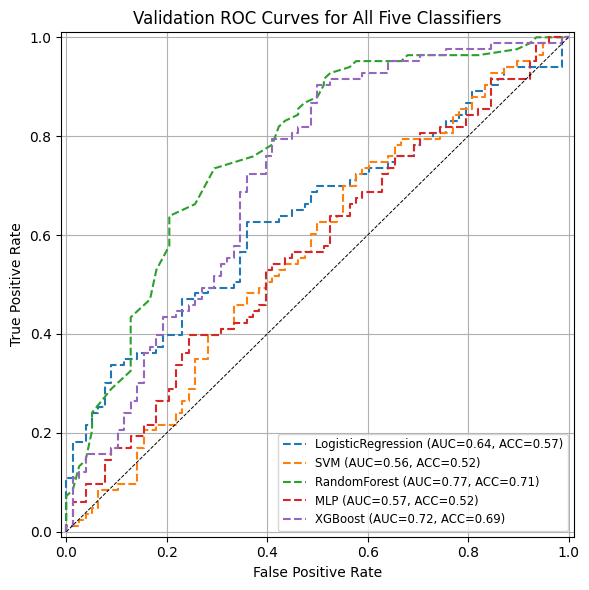

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ────────────────────────────────────────────────────────────────────────────────
# 1. Define the five classifiers (same as before)
# ────────────────────────────────────────────────────────────────────────────────
classifiers = {
    'LogisticRegression': lambda: LogisticRegression(
        solver='liblinear',
        C=1.0,
        max_iter=2000,
        random_state=42
    ),
    'SVM': lambda: SVC(
        kernel='rbf',
        C=1.0,
        probability=True,
        random_state=42
    ),
    'RandomForest': lambda: RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ),
    'MLP': lambda: MLPClassifier(
        hidden_layer_sizes=(100,),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42
    ),
    'XGBoost': lambda: xgb.XGBClassifier(
        eval_metric='logloss',
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    )
}

# ────────────────────────────────────────────────────────────────────────────────
# 2. Gene‐loop + fit each classifier, but now SAVE `train_features` instead of `selected_genes`
# ────────────────────────────────────────────────────────────────────────────────
gene_nums = list(range(5, 6000, 400))
results   = {}  # will store: results[clf_name] = {'best_features': [...], 'best_model': fitted_model}

for clf_name, clf_builder in classifiers.items():
    best_features = None
    best_model    = None
    best_auc      = -1.0

    # Re‐compute X_all exactly as in your notebook:
    tpm_df = tpm_normalized.copy()
    X_all  = tpm_df[sample_order].T
    y_all  = np.array(labels)

    print(f"\n======== Starting gene‐loop for {clf_name} ========")
    for num_genes in tqdm(gene_nums, desc=f"{clf_name} gene set size loop"):
        # 1. pick the top num_genes from ranked_genes, intersect with X_all.columns
        selected_genes = sorted(set(ranked_genes[:num_genes]) & set(X_all.columns))

        # 2. build X (samples × selected_genes) and y
        X = X_all[selected_genes].copy()
        y = y_all.copy()

        # 3. Perform 5 internal splits exactly as before
        aucs = []
        for _ in range(5):
            idx_r = np.where(y == 1)[0]
            idx_n = np.where(y == 0)[0]

            # 20 positives / 20 negatives for training
            train_r = np.random.choice(idx_r, 20, replace=False)
            train_n = np.random.choice(idx_n, 20, replace=False)

            # Remainder → test candidates
            test_r = np.setdiff1d(idx_r, train_r)
            test_n = np.setdiff1d(idx_n, train_n)

            # From those remainders, pick 12 positives & 12 negatives
            test_r = np.random.choice(test_r, 12, replace=False)
            test_n = np.random.choice(test_n, 12, replace=False)

            train_idx = np.concatenate([train_r, train_n])
            test_idx  = np.concatenate([test_r, test_n])

            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Remove any all‐zero columns in the training set
            non_zero_cols = (X_train != 0).any(axis=0)
            X_train = X_train.loc[:, non_zero_cols]
            X_test  = X_test.loc[:, non_zero_cols]

            # Fit the classifier on the 40‐sample train set
            model = clf_builder()
            model.fit(X_train, y_train)

            # Compute test‐set AUC
            y_pred_prob = model.predict_proba(X_test)[:, 1]
            aucs.append(roc_auc_score(y_test, y_pred_prob))

        current_auc = np.mean(aucs)
        if current_auc > best_auc:
            best_auc = current_auc

            # Re‐fit “best_model” on *all* samples using exactly the same non‐zero filter:
            X_full      = X_all[selected_genes].copy()
            nz_full     = (X_full != 0).any(axis=0)
            X_full      = X_full.loc[:, nz_full]
            train_features = list(X_full.columns)  # ← Save these exact column names

            refit_model = clf_builder()
            refit_model.fit(X_full, y_all)
            best_model    = refit_model
            best_features = train_features

            print(f"  → {clf_name} new best: num_genes={num_genes}, avg_internal_AUC={best_auc:.4f}")

    results[clf_name] = {
        'best_features': best_features,
        'best_model':    best_model
    }


# ────────────────────────────────────────────────────────────────────────────────
# 3. Validation + ROC plotting, REINDEXING ON `best_features`
# ────────────────────────────────────────────────────────────────────────────────

# 3.1 Load validation metadata + TPM exactly as in Cell 19:
valid_cancer_patient = pd.read_excel("data/validation_bc_meta.xlsx")
valid_normal_patient = pd.read_excel("data/validation_normal_meta.xlsx")
cancer_patients = list(valid_cancer_patient['Mapping ID'])
normal_patients = list(valid_normal_patient['Mapping ID'])

tpm_valid_df = pd.read_csv("data/validation_exon_tpm", sep='\t').T
tpm_valid_df['label'] = tpm_valid_df.index.map(
    lambda x: 1 if x in cancer_patients else (0 if x in normal_patients else np.nan)
)
valid_labels = tpm_valid_df['label'].values

# 3.2 Plot ROC curves for each best_model (one curve per classifier)
plt.figure(figsize=(6, 6))

for clf_name, res in results.items():
    best_features = res['best_features']
    best_model    = res['best_model']

    # Reindex validation DataFrame so it has exactly the same columns in the same order
    X_valid_filt = tpm_valid_df.reindex(columns=best_features, fill_value=0)

    # Now we can safely call predict_proba, without any mismatch:
    y_pred_prob_valid = best_model.predict_proba(X_valid_filt)[:, 1]

    fpr, tpr, _ = roc_curve(valid_labels, y_pred_prob_valid)
    auc_valid   = roc_auc_score(valid_labels, y_pred_prob_valid)

    y_pred        = best_model.predict(X_valid_filt)
    accuracy_valid = accuracy_score(valid_labels, y_pred)

    plt.plot(
        fpr, tpr,
        linestyle='--',
        label=f"{clf_name} (AUC={auc_valid:.2f}, ACC={accuracy_valid:.2f})"
    )

# 3.3 Final formatting
plt.plot([0, 1], [0, 1], "k--", linewidth=0.7)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curves for All Five Classifiers")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
xg_importance = pd.Series(results['XGBoost']['best_model'].feature_importances_, index=results['XGBoost']['best_model'].feature_names_in_)
xg_importance_sorted = xg_importance.sort_values(ascending=False)
print(xg_importance_sorted.head(5))

ENSG00000114374    0.102109
ENSG00000116001    0.092436
ENSG00000099866    0.068746
ENSG00000006327    0.052780
ENSG00000139239    0.043607
dtype: float32


In [45]:
rf_importance = pd.Series(results['RandomForest']['best_model'].feature_importances_, index=results['RandomForest']['best_model'].feature_names_in_)
rf_importance_sorted = rf_importance.sort_values(ascending=False)
print(rf_importance_sorted.head(5))

ENSG00000114374    0.040129
ENSG00000099725    0.028570
ENSG00000012817    0.028038
ENSG00000051523    0.012896
ENSG00000061455    0.012604
dtype: float64


# Recurrence

In [94]:
# Load expression and metadata
tpm = pd.read_csv("data/pnas_tpm_96_nodup.txt", sep='\t', header=None)
tpm.columns = ['gene_id'] + [f"C{i}" for i in range(1, tpm.shape[1])]
readcounts = pd.read_csv("data/pnas_readcounts_96_nodup.txt", sep='\t', header=None)
readcounts.columns = ['gene_id'] + [f"C{i}" for i in range(1, tpm.shape[1])]
patient_info = pd.read_csv("data/pnas_patient_info.csv")
sample_ids = [f"C{i}" for i in range(1, 97)]
patient_info["sampleID"] = sample_ids

# Filter for preselected genes
tpm = tpm.set_index('gene_id')
readcounts_filtered = readcounts.set_index('gene_id')
tpm_combined = tpm.copy()

sample_order = tpm_combined.columns
labels = patient_info['recurStatus'].map({'N': 0, 'R': 1}).values

In [95]:
with open("data/recurrence_genes_p_values.pkl", "rb") as f:
    p_values = pickle.load(f)
    
# Rank genes
ranked_genes = [gene for gene, _ in sorted(p_values, key=lambda x: x[1])]

In [96]:
max_zero_fraction = 0.9
max_zeros_allowed = int(tpm_combined.shape[1] * max_zero_fraction)
zero_counts = (tpm_combined == 0).sum(axis=1)
tpm_filtered = tpm_combined[zero_counts <= max_zeros_allowed]

In [97]:
tpm_df = tpm_filtered.copy()
X_all = tpm_df[sample_order].T


======== Starting gene‐loop for LogisticRegression ========


LogisticRegression gene set size loop:  20%|███████▊                               | 3/15 [00:00<00:00, 19.97it/s]

  → LogisticRegression new best: num_genes=5, avg_internal_AUC=0.5663
  → LogisticRegression new best: num_genes=405, avg_internal_AUC=0.8592
  → LogisticRegression new best: num_genes=805, avg_internal_AUC=0.9095


LogisticRegression gene set size loop: 100%|██████████████████████████████████████| 15/15 [00:04<00:00,  3.50it/s]



======== Starting gene‐loop for SVM ========


SVM gene set size loop:  27%|██████████████▍                                       | 4/15 [00:00<00:00, 26.43it/s]

  → SVM new best: num_genes=5, avg_internal_AUC=0.5136


SVM gene set size loop:  47%|█████████████████████████▏                            | 7/15 [00:00<00:00, 14.41it/s]

  → SVM new best: num_genes=2405, avg_internal_AUC=0.5237


SVM gene set size loop:  73%|██████████████████████████████████████▊              | 11/15 [00:01<00:00,  8.87it/s]

  → SVM new best: num_genes=3605, avg_internal_AUC=0.5716


SVM gene set size loop: 100%|█████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.36it/s]



======== Starting gene‐loop for RandomForest ========


RandomForest gene set size loop:   7%|███                                          | 1/15 [00:00<00:03,  4.06it/s]

  → RandomForest new best: num_genes=5, avg_internal_AUC=0.5609


RandomForest gene set size loop:  13%|██████                                       | 2/15 [00:00<00:03,  3.73it/s]

  → RandomForest new best: num_genes=405, avg_internal_AUC=0.8041


RandomForest gene set size loop: 100%|████████████████████████████████████████████| 15/15 [00:04<00:00,  3.13it/s]



======== Starting gene‐loop for MLP ========


MLP gene set size loop:   0%|                                                              | 0/15 [00:00<?, ?it/s]/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
MLP gene set size loop:   7%|███▌                                                  | 1/15 [00:00<00:02,  5.54it/s]

  → MLP new best: num_genes=5, avg_internal_AUC=0.6592


MLP gene set size loop:  13%|███████▏                                              | 2/15 [00:00<00:02,  4.83it/s]

  → MLP new best: num_genes=405, avg_internal_AUC=0.8450


MLP gene set size loop:  20%|██████████▊                                           | 3/15 [00:00<00:03,  3.76it/s]

  → MLP new best: num_genes=805, avg_internal_AUC=0.8734


MLP gene set size loop: 100%|█████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.60it/s]



======== Starting gene‐loop for XGBoost ========


XGBoost gene set size loop:   7%|███▎                                              | 1/15 [00:00<00:05,  2.53it/s]

  → XGBoost new best: num_genes=5, avg_internal_AUC=0.6888


XGBoost gene set size loop: 100%|█████████████████████████████████████████████████| 15/15 [00:40<00:00,  2.70s/it]


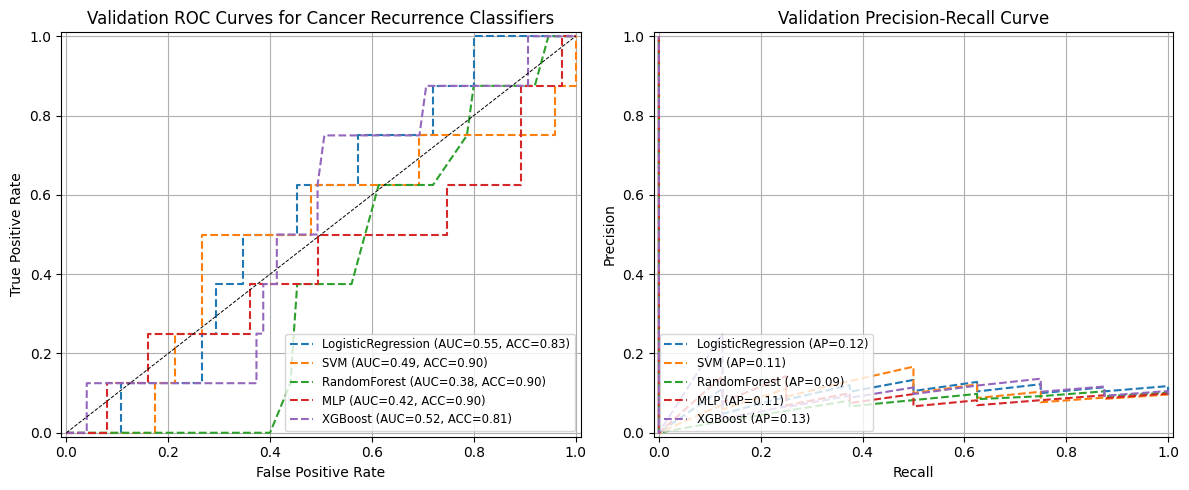

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ────────────────────────────────────────────────────────────────────────────────
# 1. Define the five classifiers (same as before)
# ────────────────────────────────────────────────────────────────────────────────
classifiers = {
    'LogisticRegression': lambda: LogisticRegression(
        solver='liblinear',
        C=1.0,
        max_iter=2000,
        random_state=42
    ),
    'SVM': lambda: SVC(
        kernel='rbf',
        C=1.0,
        probability=True,
        random_state=42
    ),
    'RandomForest': lambda: RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ),
    'MLP': lambda: MLPClassifier(
        hidden_layer_sizes=(100,),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42
    ),
    'XGBoost': lambda: xgb.XGBClassifier(
        eval_metric='logloss',
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    )
}

# ────────────────────────────────────────────────────────────────────────────────
# 2. Gene‐loop + fit each classifier, but now SAVE `train_features` instead of `selected_genes`
# ────────────────────────────────────────────────────────────────────────────────
gene_nums = list(range(5, 6000, 400))
results   = {}  # will store: results[clf_name] = {'best_features': [...], 'best_model': fitted_model}
all_aucs = {clf_name: {} for clf_name in classifiers}
all_accs = {clf_name: {} for clf_name in classifiers}

for clf_name, clf_builder in classifiers.items():
    best_features = None
    best_model    = None
    best_auc      = -1.0

    # Re‐compute X_all exactly as in your notebook:
    tpm_df = tpm_normalized.copy()
    X_all  = tpm_df[sample_order].T
    y_all  = np.array(labels)

    print(f"\n======== Starting gene‐loop for {clf_name} ========")
    for num_genes in tqdm(gene_nums, desc=f"{clf_name} gene set size loop"):
        # 1. pick the top num_genes from ranked_genes, intersect with X_all.columns
        selected_genes = sorted(set(ranked_genes[:num_genes]) & set(X_all.columns))

        # 2. build X (samples × selected_genes) and y
        X = X_all[selected_genes].copy()
        y = y_all.copy()

        # 3. Perform 5 internal splits exactly as before
        aucs = []
        accs = []
        for _ in range(5):
            idx_r = np.where(y == 1)[0]
            idx_n = np.where(y == 0)[0]

            # 20 positives / 20 negatives for training
            train_r = np.random.choice(idx_r, 15, replace=False)
            train_n = np.random.choice(idx_n, 15, replace=False)

            # Remainder → test candidates
            test_r = np.setdiff1d(idx_r, train_r)
            test_n = np.setdiff1d(idx_n, train_n)

            # From those remainders, pick 12 positives & 12 negatives
            test_r = np.random.choice(test_r, 13, replace=False)
            test_n = np.random.choice(test_n, 13, replace=False)

            train_idx = np.concatenate([train_r, train_n])
            test_idx  = np.concatenate([test_r, test_n])

            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Remove any all‐zero columns in the training set
            non_zero_cols = (X_train != 0).any(axis=0)
            X_train = X_train.loc[:, non_zero_cols]
            X_test  = X_test.loc[:, non_zero_cols]

            # Fit the classifier on the 40‐sample train set
            model = clf_builder()
            model.fit(X_train, y_train)

            # Compute test‐set AUC
            y_pred_prob = model.predict_proba(X_test)[:, 1]
            acc = accuracy_score(y_test, model.predict(X_test))
            auc = roc_auc_score(y_test, y_pred_prob)
            aucs.append(auc)
            accs.append(acc)

        current_auc = np.mean(aucs)
        all_aucs[clf_name][num_genes] = aucs
        all_accs[clf_name][num_genes] = accs
        if current_auc > best_auc:
            best_auc = current_auc

            # Re‐fit “best_model” on *all* samples using exactly the same non‐zero filter:
            X_full      = X_all[selected_genes].copy()
            nz_full     = (X_full != 0).any(axis=0)
            X_full      = X_full.loc[:, nz_full]
            train_features = list(X_full.columns)  # ← Save these exact column names

            refit_model = clf_builder()
            refit_model.fit(X_full, y_all)
            best_model    = refit_model
            best_features = train_features

            print(f"  → {clf_name} new best: num_genes={num_genes}, avg_internal_AUC={best_auc:.4f}")

    results[clf_name] = {
        'best_features': best_features,
        'best_model':    best_model
    }


# ────────────────────────────────────────────────────────────────────────────────
# 3. Validation + ROC plotting, REINDEXING ON `best_features`
# ────────────────────────────────────────────────────────────────────────────────

# 3.1 Load validation metadata + TPM exactly as in Cell 19:
valid_cancer_patient = pd.read_excel("data/validation_bc_meta.xlsx")
cancer_patients = list(valid_cancer_patient['Mapping ID'])

# Load expression and metadata
tpm_valid = pd.read_csv("data/validation_exon_tpm", sep='\t')
tpm_valid = tpm_valid[cancer_patients]

tpm_df = tpm_valid.T
tpm_df = tpm_df.sort_index()
sort_patients = tpm_df.index
label_map = valid_cancer_patient.set_index('Mapping ID')[
    'Recurrence Staus at the time of collection'
].map({'Nonrecurrent': 0, 'Recurrent': 1})
valid_labels = tpm_df.index.to_series().map(label_map).values

# 3.2 Plot ROC curves for each best_model (one curve per classifier)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ── ROC Curve Plot ──
ax_roc = axes[0]
for clf_name, res in results.items():
    best_features = res['best_features']
    best_model = res['best_model']

    X_valid_filt = tpm_df.reindex(columns=best_features, fill_value=0)
    y_pred_prob = best_model.predict_proba(X_valid_filt)[:, 1]
    y_pred = best_model.predict(X_valid_filt)

    fpr, tpr, _ = roc_curve(valid_labels, y_pred_prob)
    auc = roc_auc_score(valid_labels, y_pred_prob)
    acc = accuracy_score(valid_labels, y_pred)

    ax_roc.plot(fpr, tpr, linestyle='--', label=f"{clf_name} (AUC={auc:.2f}, ACC={acc:.2f})")

ax_roc.plot([0, 1], [0, 1], "k--", linewidth=0.7)
ax_roc.set_xlim([-0.01, 1.01])
ax_roc.set_ylim([-0.01, 1.01])
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_title("Validation ROC Curves for Cancer Recurrence Classifiers")
ax_roc.legend(loc="lower right", fontsize='small')
ax_roc.grid(True)

# ── Precision-Recall Plot ──
ax_pr = axes[1]
for clf_name, res in results.items():
    best_features = res['best_features']
    best_model = res['best_model']

    X_valid_filt = tpm_df.reindex(columns=best_features, fill_value=0)
    y_pred_prob = best_model.predict_proba(X_valid_filt)[:, 1]

    precision, recall, _ = precision_recall_curve(valid_labels, y_pred_prob)
    ap = average_precision_score(valid_labels, y_pred_prob)

    ax_pr.plot(recall, precision, linestyle='--', label=f"{clf_name} (AP={ap:.2f})")

ax_pr.set_xlim([-0.01, 1.01])
ax_pr.set_ylim([-0.01, 1.01])
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.set_title("Validation Precision-Recall Curve")
ax_pr.legend(loc="lower left", fontsize='small')
ax_pr.grid(True)

plt.tight_layout()
plt.show()

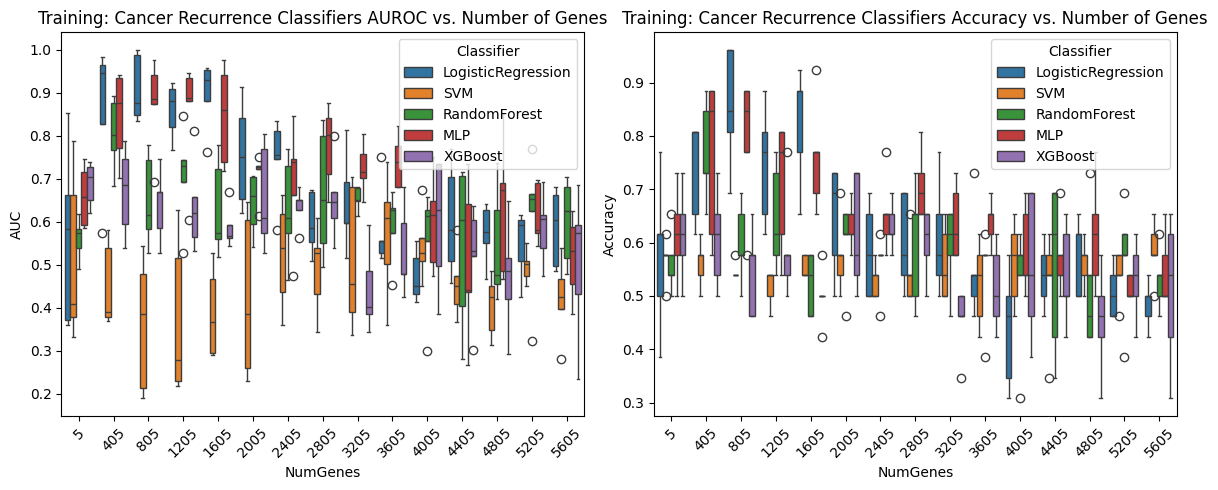

In [107]:
df_auc = pd.DataFrame([
    {'Classifier': clf, 'NumGenes': k, 'AUC': v}
    for clf, values in all_aucs.items()
    for k, lst in values.items()
    for v in lst])
df_acc = pd.DataFrame([
    {'Classifier': clf, 'NumGenes': k, 'Accuracy': v}
    for clf, values in all_accs.items()
    for k, lst in values.items()
    for v in lst])

plt.figure(figsize=(12, 5))

# AUROC
plt.subplot(1, 2, 1)
sns.boxplot(data=df_auc, x="NumGenes", y="AUC", hue="Classifier")
plt.title("Training: Cancer Recurrence Classifiers AUROC vs. Number of Genes")
plt.xticks(rotation=45)

# Accuracy
plt.subplot(1, 2, 2)
sns.boxplot(data=df_acc, x="NumGenes", y="Accuracy", hue="Classifier")
plt.title("Training: Cancer Recurrence Classifiers Accuracy vs. Number of Genes")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


======== Starting gene‐loop for LogisticRegression ========


LogisticRegression gene set size loop:  20%|████████████████████▏                                                                                | 3/15 [00:00<00:00, 25.27it/s]

  → LogisticRegression new best: num_genes=5, avg_internal_AUC=0.6775
  → LogisticRegression new best: num_genes=405, avg_internal_AUC=0.8432
  → LogisticRegression new best: num_genes=1205, avg_internal_AUC=0.8456


LogisticRegression gene set size loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.96it/s]



======== Starting gene‐loop for SVM ========


SVM gene set size loop:  27%|██████████████████████████████▉                                                                                     | 4/15 [00:00<00:00, 33.71it/s]

  → SVM new best: num_genes=5, avg_internal_AUC=0.2627
  → SVM new best: num_genes=405, avg_internal_AUC=0.4781
  → SVM new best: num_genes=1605, avg_internal_AUC=0.5006


SVM gene set size loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 11.47it/s]


  → SVM new best: num_genes=5605, avg_internal_AUC=0.5089

======== Starting gene‐loop for RandomForest ========


RandomForest gene set size loop:   7%|███████▏                                                                                                   | 1/15 [00:00<00:03,  4.36it/s]

  → RandomForest new best: num_genes=5, avg_internal_AUC=0.6024


RandomForest gene set size loop:  13%|██████████████▎                                                                                            | 2/15 [00:00<00:03,  4.00it/s]

  → RandomForest new best: num_genes=405, avg_internal_AUC=0.6858


RandomForest gene set size loop:  20%|█████████████████████▍                                                                                     | 3/15 [00:00<00:03,  3.77it/s]

  → RandomForest new best: num_genes=805, avg_internal_AUC=0.7041


RandomForest gene set size loop:  27%|████████████████████████████▌                                                                              | 4/15 [00:01<00:03,  3.58it/s]

  → RandomForest new best: num_genes=1205, avg_internal_AUC=0.7355


RandomForest gene set size loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.43it/s]



======== Starting gene‐loop for MLP ========


MLP gene set size loop:   0%|                                                                                                                            | 0/15 [00:00<?, ?it/s]/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/shuhaoxu/mambaforge/envs/stats/lib/python3.10/sit

  → MLP new best: num_genes=5, avg_internal_AUC=0.7047


MLP gene set size loop:  13%|███████████████▍                                                                                                    | 2/15 [00:00<00:02,  4.44it/s]

  → MLP new best: num_genes=405, avg_internal_AUC=0.8852


MLP gene set size loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.23it/s]



======== Starting gene‐loop for XGBoost ========


XGBoost gene set size loop:   7%|███████▍                                                                                                        | 1/15 [00:00<00:05,  2.61it/s]

  → XGBoost new best: num_genes=5, avg_internal_AUC=0.6586


XGBoost gene set size loop:  33%|█████████████████████████████████████▎                                                                          | 5/15 [00:04<00:12,  1.22s/it]

  → XGBoost new best: num_genes=1605, avg_internal_AUC=0.6769


XGBoost gene set size loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:38<00:00,  2.54s/it]


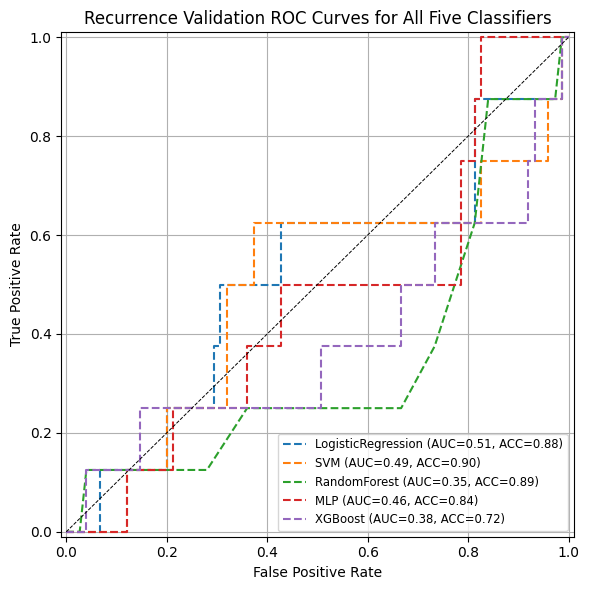

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ────────────────────────────────────────────────────────────────────────────────
# 1. Define the five classifiers (same as before)
# ────────────────────────────────────────────────────────────────────────────────
classifiers = {
    'LogisticRegression': lambda: LogisticRegression(
        solver='liblinear',
        C=1.0,
        max_iter=2000,
        random_state=42
    ),
    'SVM': lambda: SVC(
        kernel='rbf',
        C=1.0,
        probability=True,
        random_state=42
    ),
    'RandomForest': lambda: RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ),
    'MLP': lambda: MLPClassifier(
        hidden_layer_sizes=(100,),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42
    ),
    'XGBoost': lambda: xgb.XGBClassifier(
        eval_metric='logloss',
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    )
}

# ────────────────────────────────────────────────────────────────────────────────
# 2. Gene‐loop + fit each classifier, but now SAVE `train_features` instead of `selected_genes`
# ────────────────────────────────────────────────────────────────────────────────
gene_nums = list(range(5, 6000, 400))
results   = {}  # will store: results[clf_name] = {'best_features': [...], 'best_model': fitted_model}

for clf_name, clf_builder in classifiers.items():
    best_features = None
    best_model    = None
    best_auc      = -1.0

    # Re‐compute X_all exactly as in your notebook:
    tpm_df = tpm_normalized.copy()
    X_all  = tpm_df[sample_order].T
    y_all  = np.array(labels)

    print(f"\n======== Starting gene‐loop for {clf_name} ========")
    for num_genes in tqdm(gene_nums, desc=f"{clf_name} gene set size loop"):
        # 1. pick the top num_genes from ranked_genes, intersect with X_all.columns
        selected_genes = sorted(set(ranked_genes[:num_genes]) & set(X_all.columns))

        # 2. build X (samples × selected_genes) and y
        X = X_all[selected_genes].copy()
        y = y_all.copy()

        # 3. Perform 5 internal splits exactly as before
        aucs = []
        for _ in range(5):
            idx_r = np.where(y == 1)[0]
            idx_n = np.where(y == 0)[0]

            # 20 positives / 20 negatives for training
            train_r = np.random.choice(idx_r, 15, replace=False)
            train_n = np.random.choice(idx_n, 15, replace=False)

            # Remainder → test candidates
            test_r = np.setdiff1d(idx_r, train_r)
            test_n = np.setdiff1d(idx_n, train_n)

            # From those remainders, pick 12 positives & 12 negatives
            test_r = np.random.choice(test_r, 13, replace=False)
            test_n = np.random.choice(test_n, 13, replace=False)

            train_idx = np.concatenate([train_r, train_n])
            test_idx  = np.concatenate([test_r, test_n])

            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Remove any all‐zero columns in the training set
            non_zero_cols = (X_train != 0).any(axis=0)
            X_train = X_train.loc[:, non_zero_cols]
            X_test  = X_test.loc[:, non_zero_cols]

            # Fit the classifier on the 40‐sample train set
            model = clf_builder()
            model.fit(X_train, y_train)

            # Compute test‐set AUC
            y_pred_prob = model.predict_proba(X_test)[:, 1]
            aucs.append(roc_auc_score(y_test, y_pred_prob))

        current_auc = np.mean(aucs)
        if current_auc > best_auc:
            best_auc = current_auc

            # Re‐fit “best_model” on *all* samples using exactly the same non‐zero filter:
            X_full      = X_all[selected_genes].copy()
            nz_full     = (X_full != 0).any(axis=0)
            X_full      = X_full.loc[:, nz_full]
            train_features = list(X_full.columns)  # ← Save these exact column names

            refit_model = clf_builder()
            refit_model.fit(X_full, y_all)
            best_model    = refit_model
            best_features = train_features

            print(f"  → {clf_name} new best: num_genes={num_genes}, avg_internal_AUC={best_auc:.4f}")

    results[clf_name] = {
        'best_features': best_features,
        'best_model':    best_model
    }


# ────────────────────────────────────────────────────────────────────────────────
# 3. Validation + ROC plotting, REINDEXING ON `best_features`
# ────────────────────────────────────────────────────────────────────────────────

# 3.1 Load validation metadata + TPM exactly as in Cell 19:
valid_cancer_patient = pd.read_excel("data/validation_bc_meta.xlsx")
cancer_patients = list(valid_cancer_patient['Mapping ID'])

# Load expression and metadata
tpm_valid = pd.read_csv("data/validation_exon_tpm", sep='\t')
tpm_valid = tpm_valid[cancer_patients]

tpm_df = tpm_valid.T
tpm_df = tpm_df.sort_index()
sort_patients = tpm_df.index
label_map = valid_cancer_patient.set_index('Mapping ID')[
    'Recurrence Staus at the time of collection'
].map({'Nonrecurrent': 0, 'Recurrent': 1})
valid_labels = tpm_df.index.to_series().map(label_map).values

# 3.2 Plot ROC curves for each best_model (one curve per classifier)
plt.figure(figsize=(6, 6))

for clf_name, res in results.items():
    best_features = res['best_features']
    best_model    = res['best_model']

    # Reindex validation DataFrame so it has exactly the same columns in the same order
    X_valid_filt = tpm_df.reindex(columns=best_features, fill_value=0)

    # Now we can safely call predict_proba, without any mismatch:
    y_pred_prob_valid = best_model.predict_proba(X_valid_filt)[:, 1]

    fpr, tpr, _ = roc_curve(valid_labels, y_pred_prob_valid)
    auc_valid   = roc_auc_score(valid_labels, y_pred_prob_valid)

    y_pred        = best_model.predict(X_valid_filt)
    accuracy_valid = accuracy_score(valid_labels, y_pred)

    plt.plot(
        fpr, tpr,
        linestyle='--',
        label=f"{clf_name} (AUC={auc_valid:.2f}, ACC={accuracy_valid:.2f})"
    )

# 3.3 Final formatting
plt.plot([0, 1], [0, 1], "k--", linewidth=0.7)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Recurrence Validation ROC Curves for All Five Classifiers")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
xg_importance = pd.Series(results['XGBoost']['best_model'].feature_importances_, index=results['XGBoost']['best_model'].feature_names_in_)
xg_importance_sorted = xg_importance.sort_values(ascending=False)
print(xg_importance_sorted.head(5))

ENSG00000104760    0.047265
ENSG00000008438    0.045054
ENSG00000141985    0.030029
ENSG00000026559    0.027325
ENSG00000049245    0.026018
dtype: float32


In [52]:
rf_importance = pd.Series(results['RandomForest']['best_model'].feature_importances_, index=results['RandomForest']['best_model'].feature_names_in_)
rf_importance_sorted = rf_importance.sort_values(ascending=False)
print(rf_importance_sorted.head(5))

ENSG00000141985    0.009882
ENSG00000124216    0.009297
ENSG00000136045    0.008792
ENSG00000033050    0.008228
ENSG00000111796    0.007700
dtype: float64
